<a href="https://colab.research.google.com/github/csusheel371-dotcom/meme-and-poster/blob/main/AI_Meme_%26_Poster_Creator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install -q requests==2.32.4 google-genai==1.40.0 pillow



In [16]:
from getpass import getpass
import os, textwrap, re, requests
from PIL import Image, ImageDraw, ImageFont
from google import genai
from IPython.display import display


In [17]:
api_key = getpass("Paste your Gemini API key: ")
if api_key:
    os.environ["GEMINI_API_KEY"] = api_key

client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))
print("Gemini client initialized!")


Paste your Gemini API key: ··········
Gemini client initialized!


In [20]:
print("Available models:")
models_pager = client.models.list()  # returns a Pager
for m in models_pager:
    print(m.name)

# After checking, pick a valid model for content generation:
MODEL_NAME = "gemini-1.5"  # <-- update based on the list you see


Available models:
models/embedding-gecko-001
models/gemini-2.5-pro-preview-03-25
models/gemini-2.5-flash-preview-05-20
models/gemini-2.5-flash
models/gemini-2.5-flash-lite-preview-06-17
models/gemini-2.5-pro-preview-05-06
models/gemini-2.5-pro-preview-06-05
models/gemini-2.5-pro
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-preview-image-generation
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.0-flash-thinking-exp-01-21
models/gemini-2.0-flash-thinking-exp
models/gemini-2.0-flash-thinking-exp-1219
models/gemini-2.5-flash-preview-tts
models/gemini-2.5-pro-preview-tts
models/learnlm-2.0-flash-experimental
models/gemma-3-1b-it
models/gemma-3-4b-it
models/gemma-3-12b-it
models/gemma-3-27b-it
models/

In [21]:
!wget -q -O /content/Bangers-Regular.ttf https://github.com/google/fonts/raw/main/ofl/bangers/Bangers-Regular.ttf
!wget -q -O /content/Montserrat-SemiBold.ttf https://github.com/google/fonts/raw/main/ofl/montserrat/Montserrat-SemiBold.ttf

FONT_BANGERS = "/content/Bangers-Regular.ttf"
FONT_MONTSERRAT = "/content/Montserrat-SemiBold.ttf"
print("Fonts downloaded successfully!")


Fonts downloaded successfully!


In [26]:
def draw_text_on_image(img, text, font_path=FONT_BANGERS, position='bottom', padding=40):
    img = img.convert("RGBA")
    W, H = img.size
    draw = ImageDraw.Draw(img)
    font_size = max(18, int(W / 15))
    font = ImageFont.truetype(font_path, font_size)

    # Pillow >=10 compatible
    avg_char_w = sum((font.getbbox(c)[2]-font.getbbox(c)[0]) for c in "abcdefghijklmnopqrstuvwxyz")/26.0
    max_chars = max(10, int((W*0.9)/max(1, avg_char_w)))
    wrapped = textwrap.fill(text, width=max_chars)

    # Updated for Pillow >=10
    bbox = draw.multiline_textbbox((0,0), wrapped, font=font)
    tw = bbox[2] - bbox[0]
    th = bbox[3] - bbox[1]

    x = (W - tw) / 2
    y = (H - th - padding) if position=='bottom' else padding

    stroke = max(2, int(font_size * 0.06))
    for dx in range(-stroke, stroke+1):
        for dy in range(-stroke, stroke+1):
            if dx==0 and dy==0: continue
            draw.multiline_text((x+dx, y+dy), wrapped, font=font, fill=(0,0,0,200), align='center')
    draw.multiline_text((x, y), wrapped, font=font, fill=(255,255,255,255), align='center')
    return img.convert("RGB")


In [23]:
def generate_captions_gemini(keywords, n=3, model=MODEL_NAME):
    prompt = f"Generate {n} short, punchy captions for: {keywords}. Keep 1-2 short lines."
    try:
        resp = client.models.generate_content(model=model, contents=prompt)
        text = resp.text or ""
        lines = [re.sub(r'^[\-\d\.\)\s]+','', ln).strip() for ln in text.splitlines() if ln.strip()]
        if len(lines)<n:
            parts = [p.strip() for p in re.split(r'[。\n.!?]+', text) if p.strip()]
            for p in parts:
                if p not in lines:
                    lines.append(p)
        return lines[:n]
    except Exception as e:
        print("Error generating captions:", type(e).__name__, str(e))
        return [keywords]


In [24]:
def create_meme_from_image(pil_img, keywords, style='meme'):
    captions = generate_captions_gemini(keywords, n=3)
    chosen = captions[0] if captions else keywords
    font = FONT_BANGERS if style=='meme' else FONT_MONTSERRAT
    pos = 'bottom' if style=='meme' else 'top'
    out_img = draw_text_on_image(pil_img.copy(), chosen, font_path=font, position=pos)
    return out_img, captions


In [ ]:
# Download a random sample image
resp = requests.get("https://picsum.photos/900/600", stream=True)
img = Image.open(resp.raw).convert("RGB")

# Generate meme/poster
result_img, caption_options = create_meme_from_image(
    img,
    keywords="college fest music food friends",
    style='meme'
)

print("Caption options:", caption_options)
display(result_img)


Saving an.jpg to an.jpg
Error generating captions: ClientError 404 NOT_FOUND. {'error': {'code': 404, 'message': 'models/gemini-1.5 is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.', 'status': 'NOT_FOUND'}}
Caption options: ['college fest music food friends']


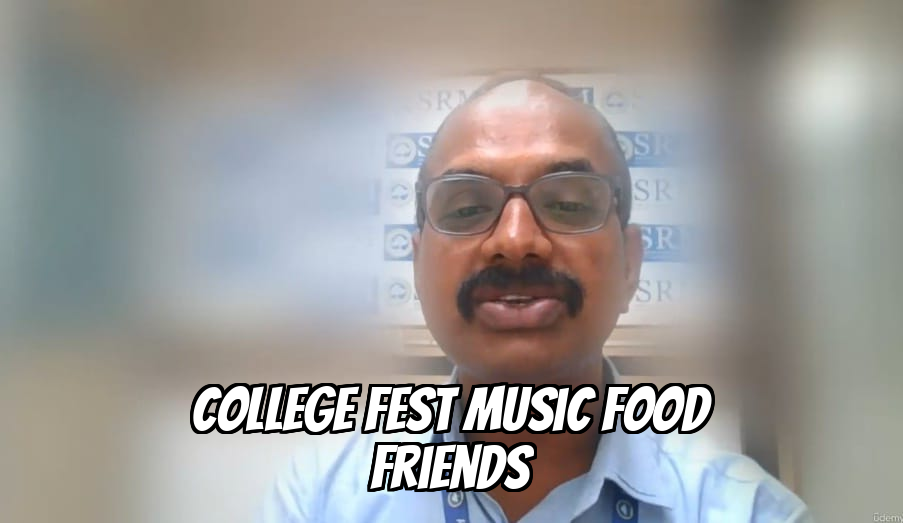

In [30]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    img = Image.open(fn).convert("RGB")
    result_img, caption_options = create_meme_from_image(img, "college fest music food friends", style='meme')
    print("Caption options:", caption_options)
    display(result_img)
